In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from timm import create_model
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

# Configuration with enhancements for 90%+ accuracy
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'model_name': 'deit_tiny_patch16_224',  # Changed to diet_tiny
    'batch_size': 32,
    'img_size': 224,
    'weight_decay': 0.01,
    'epochs': 80,
    'num_workers': 0,
    'pin_memory': True,
    'patience': 12,
    'drop_rate': 0.4,
    'drop_path_rate': 0.2,
    'head_lr': 1e-3,
    'head_epochs': 10,
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.4
}

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        self.classes = sorted([d for d in os.listdir(self.data_dir)
                               if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Found {len(self.image_paths)} images in {split} set")
        print(f"Classes: {self.classes}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
def get_enhanced_transforms(img_size):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

# Create datasets and dataloaders
train_transform, val_transform = get_enhanced_transforms(config['img_size'])
train_dataset = MelSpectrogramDataset(config['base_dir'], 'train', train_transform)
val_dataset = MelSpectrogramDataset(config['base_dir'], 'validation', val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Found 4021 images in train set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Found 73 images in validation set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Number of classes: 6


In [9]:
# SpecAugment Implementation
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param, time_mask_param, num_freq_masks=1, num_time_masks=1):
        super(SpecAugment, self).__init__()
        self.F = freq_mask_param
        self.T = time_mask_param
        self.num_freq_masks = num_freq_masks
        self.num_time_masks = num_time_masks

    def forward(self, x):
        sh = x.shape
        for _ in range(self.num_freq_masks):
            f = np.random.uniform(0.0, self.F)
            f0 = np.random.randint(0, sh[2] - int(f))
            x[:, :, f0:f0+int(f), :] = 0
        for _ in range(self.num_time_masks):
            t = np.random.uniform(0.0, self.T)
            t0 = np.random.randint(0, sh[3] - int(t))
            x[:, :, :, t0:t0+int(t)] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=25, time_mask_param=40).to(device)

In [10]:
class EnhancedDietTransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.3, drop_path_rate=0.2):
        super().__init__()

        self.backbone = create_model(
            model_name,
            pretrained=True,
            num_classes=0,  # Remove original classifier
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate
        )

        # Get the correct feature dimension from the model
        feature_dim = self.backbone.num_features
        print(f"Feature dimension for {model_name}: {feature_dim}")

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

model = EnhancedDietTransformerClassifier(
    config['model_name'], num_classes, config['drop_rate'], config['drop_path_rate']
).to(device)

print("Model created successfully!")

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Feature dimension for deit_tiny_patch16_224: 192
Model created successfully!


In [12]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Apply SpecAugment on the batch
        images = spec_augment(images)

        # Apply Mixup
        images, targets_a, targets_b, lam = mixup_data(images, labels, config['mixup_alpha'])
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # Calculate loss with Mixup
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        
        # For accuracy calculation, use the original non-mixed labels
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader), accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader), accuracy, all_preds, all_labels

print("Training utilities defined!")

Training utilities defined!


In [14]:
# PHASE 1: Train only the classification head
print("=== PHASE 1: Training only the classification head ===")

for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
optimizer = optim.AdamW(model.classifier.parameters(), lr=config['head_lr'], weight_decay=config['weight_decay'])

best_head_acc = 0
for epoch in range(config['head_epochs']):
    print(f"\nEpoch {epoch+1}/{config['head_epochs']}")
    # Disable Mixup for head training for simplicity and stability
    original_mixup_alpha = config['mixup_alpha']
    config['mixup_alpha'] = 0.0
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    
    config['mixup_alpha'] = original_mixup_alpha

    print(f"Head Training - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Head Training - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_head_acc:
        best_head_acc = val_acc
        torch.save(model.state_dict(), 'best_head_model_diet.pth')
        print(f"✅ New best head model saved! Accuracy: {val_acc:.4f}")

print(f"\n🎯 Phase 1 completed! Best head accuracy: {best_head_acc:.4f}")
model.load_state_dict(torch.load('best_head_model_diet.pth'))
print("Best head model loaded for Phase 2!")

=== PHASE 1: Training only the classification head ===

Epoch 1/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s, Loss=1.0739]


Head Training - Train Loss: 1.4767, Train Acc: 0.4422
Head Training - Val Loss: 1.1182, Val Acc: 0.6301
✅ New best head model saved! Accuracy: 0.6301

Epoch 2/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s, Loss=1.2422]


Head Training - Train Loss: 1.3780, Train Acc: 0.4939
Head Training - Val Loss: 1.1385, Val Acc: 0.6986
✅ New best head model saved! Accuracy: 0.6986

Epoch 3/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s, Loss=1.3053]


Head Training - Train Loss: 1.3804, Train Acc: 0.4902
Head Training - Val Loss: 1.1556, Val Acc: 0.6712

Epoch 4/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s, Loss=1.2974]


Head Training - Train Loss: 1.3654, Train Acc: 0.4947
Head Training - Val Loss: 1.1320, Val Acc: 0.6712

Epoch 5/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s, Loss=1.1461]


Head Training - Train Loss: 1.3558, Train Acc: 0.4981
Head Training - Val Loss: 1.0771, Val Acc: 0.6849

Epoch 6/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s, Loss=1.2624]


Head Training - Train Loss: 1.3434, Train Acc: 0.5029
Head Training - Val Loss: 1.1152, Val Acc: 0.7123
✅ New best head model saved! Accuracy: 0.7123

Epoch 7/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.58it/s, Loss=1.0981]


Head Training - Train Loss: 1.3404, Train Acc: 0.5014
Head Training - Val Loss: 1.0810, Val Acc: 0.7123

Epoch 8/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s, Loss=1.1980]


Head Training - Train Loss: 1.3216, Train Acc: 0.5272
Head Training - Val Loss: 1.0957, Val Acc: 0.6986

Epoch 9/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s, Loss=0.9374]


Head Training - Train Loss: 1.3446, Train Acc: 0.5046
Head Training - Val Loss: 1.0356, Val Acc: 0.6712

Epoch 10/10


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s, Loss=1.1391]

Head Training - Train Loss: 1.3277, Train Acc: 0.5153
Head Training - Val Loss: 1.0774, Val Acc: 0.7534
✅ New best head model saved! Accuracy: 0.7534

🎯 Phase 1 completed! Best head accuracy: 0.7534
Best head model loaded for Phase 2!


In [15]:
# PHASE 2: Full network training
print("\n=== PHASE 2: Full network training ===")

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=config['full_train_lr'], weight_decay=config['weight_decay'])

# Scheduler with Warmup
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: min(1., (epoch + 1) / config['lr_warmup_epochs'])
)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config['epochs'] - config['lr_warmup_epochs']
)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                return True
        else:
            self.best_score = score
            self.epochs_no_improve = 0
            self.save_checkpoint(model)
        return False

    def save_checkpoint(self, model):
        self.best_model_wts = model.state_dict().copy()

early_stopping = EarlyStopping(patience=config['patience'])

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

for epoch in range(config['epochs']):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    
    # Apply scheduler
    if epoch < config['lr_warmup_epochs']:
        warmup_scheduler.step()
    else:
        main_scheduler.step()
        
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Full Training - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Full Training - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_full_model_diet.pth')
        print(f"🎯 New best full model saved! Accuracy: {val_acc:.4f}")
    
    if early_stopping(val_loss, model):
        print("🛑 Early stopping triggered!")
        model.load_state_dict(early_stopping.best_model_wts)
        break

print(f"\nPhase 2 completed! Best validation accuracy: {best_val_acc:.4f}")


=== PHASE 2: Full network training ===

Epoch 1/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s, Loss=0.9288]


Full Training - Train Loss: 1.4175, Train Acc: 0.3877
Full Training - Val Loss: 0.9830, Val Acc: 0.7534
Learning Rate: 2.00e-05
🎯 New best full model saved! Accuracy: 0.7534

Epoch 2/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s, Loss=0.9730]


Full Training - Train Loss: 1.3847, Train Acc: 0.3914
Full Training - Val Loss: 0.9633, Val Acc: 0.7534
Learning Rate: 3.00e-05

Epoch 3/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s, Loss=0.9477]


Full Training - Train Loss: 1.3315, Train Acc: 0.4106
Full Training - Val Loss: 0.9582, Val Acc: 0.7260
Learning Rate: 4.00e-05

Epoch 4/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s, Loss=0.7902]


Full Training - Train Loss: 1.3123, Train Acc: 0.4181
Full Training - Val Loss: 0.8736, Val Acc: 0.8082
Learning Rate: 5.00e-05
🎯 New best full model saved! Accuracy: 0.8082

Epoch 5/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s, Loss=0.8199]


Full Training - Train Loss: 1.2787, Train Acc: 0.4464
Full Training - Val Loss: 0.8803, Val Acc: 0.7260
Learning Rate: 5.00e-05

Epoch 6/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s, Loss=0.8053]


Full Training - Train Loss: 1.2138, Train Acc: 0.4372
Full Training - Val Loss: 0.8875, Val Acc: 0.7260
Learning Rate: 5.00e-05

Epoch 7/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s, Loss=0.7833]


Full Training - Train Loss: 1.1789, Train Acc: 0.5066
Full Training - Val Loss: 0.8542, Val Acc: 0.7260
Learning Rate: 4.99e-05

Epoch 8/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s, Loss=0.9097]


Full Training - Train Loss: 1.1459, Train Acc: 0.5205
Full Training - Val Loss: 0.9050, Val Acc: 0.7260
Learning Rate: 4.98e-05

Epoch 9/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s, Loss=0.7993]


Full Training - Train Loss: 1.1798, Train Acc: 0.4529
Full Training - Val Loss: 0.8304, Val Acc: 0.7808
Learning Rate: 4.96e-05

Epoch 10/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s, Loss=0.9076]


Full Training - Train Loss: 1.1005, Train Acc: 0.4815
Full Training - Val Loss: 0.8964, Val Acc: 0.7808
Learning Rate: 4.95e-05

Epoch 11/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s, Loss=0.9897]


Full Training - Train Loss: 1.1312, Train Acc: 0.5131
Full Training - Val Loss: 0.8831, Val Acc: 0.7671
Learning Rate: 4.92e-05

Epoch 12/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s, Loss=0.7707]


Full Training - Train Loss: 1.0921, Train Acc: 0.5118
Full Training - Val Loss: 0.8339, Val Acc: 0.8082
Learning Rate: 4.89e-05

Epoch 13/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s, Loss=0.9051]


Full Training - Train Loss: 1.0445, Train Acc: 0.4966
Full Training - Val Loss: 0.8605, Val Acc: 0.7808
Learning Rate: 4.86e-05

Epoch 14/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s, Loss=1.0545]


Full Training - Train Loss: 1.0136, Train Acc: 0.4800
Full Training - Val Loss: 0.9244, Val Acc: 0.7123
Learning Rate: 4.82e-05

Epoch 15/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s, Loss=1.0633]


Full Training - Train Loss: 1.0375, Train Acc: 0.4964
Full Training - Val Loss: 0.9538, Val Acc: 0.7397
Learning Rate: 4.78e-05

Epoch 16/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s, Loss=0.5564]


Full Training - Train Loss: 1.0163, Train Acc: 0.5446
Full Training - Val Loss: 0.7749, Val Acc: 0.7808
Learning Rate: 4.74e-05

Epoch 17/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s, Loss=0.7853]


Full Training - Train Loss: 1.0079, Train Acc: 0.5058
Full Training - Val Loss: 0.8480, Val Acc: 0.7808
Learning Rate: 4.69e-05

Epoch 18/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s, Loss=0.9541]


Full Training - Train Loss: 1.0115, Train Acc: 0.5215
Full Training - Val Loss: 0.8506, Val Acc: 0.7945
Learning Rate: 4.64e-05

Epoch 19/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.71it/s, Loss=0.9356]


Full Training - Train Loss: 0.9702, Train Acc: 0.5673
Full Training - Val Loss: 0.9214, Val Acc: 0.7808
Learning Rate: 4.58e-05

Epoch 20/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s, Loss=0.7978]


Full Training - Train Loss: 0.9777, Train Acc: 0.5722
Full Training - Val Loss: 0.8140, Val Acc: 0.7945
Learning Rate: 4.52e-05

Epoch 21/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s, Loss=0.9330]


Full Training - Train Loss: 0.9989, Train Acc: 0.5083
Full Training - Val Loss: 0.8833, Val Acc: 0.7945
Learning Rate: 4.46e-05

Epoch 22/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s, Loss=1.1110]


Full Training - Train Loss: 0.9154, Train Acc: 0.5737
Full Training - Val Loss: 0.9765, Val Acc: 0.7397
Learning Rate: 4.39e-05

Epoch 23/80


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s, Loss=0.9064]


Full Training - Train Loss: 0.9397, Train Acc: 0.5909
Full Training - Val Loss: 0.8694, Val Acc: 0.7808
Learning Rate: 4.32e-05

Epoch 24/80


Training:   6%|▋         | 8/126 [00:02<00:38,  3.04it/s, Loss=1.4745]


KeyboardInterrupt: 


=== FINAL EVALUATION ON TEST SET ===
Found 74 images in test set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s, Loss=0.9653]



Final Test Accuracy: 0.6622 (66.22%)
Final Test Loss: 0.9633

Test Set Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.4000    0.4615    0.4286        13
           Laryngozele     0.4000    0.4444    0.4211         9
           Vox senilis     0.8571    0.4615    0.6000        13
             parkinson     0.8125    1.0000    0.8966        13
spasmodische_dysphonie     0.5385    0.5385    0.5385        13

              accuracy                         0.6622        74
             macro avg     0.6680    0.6510    0.6474        74
          weighted avg     0.6825    0.6622    0.6597        74



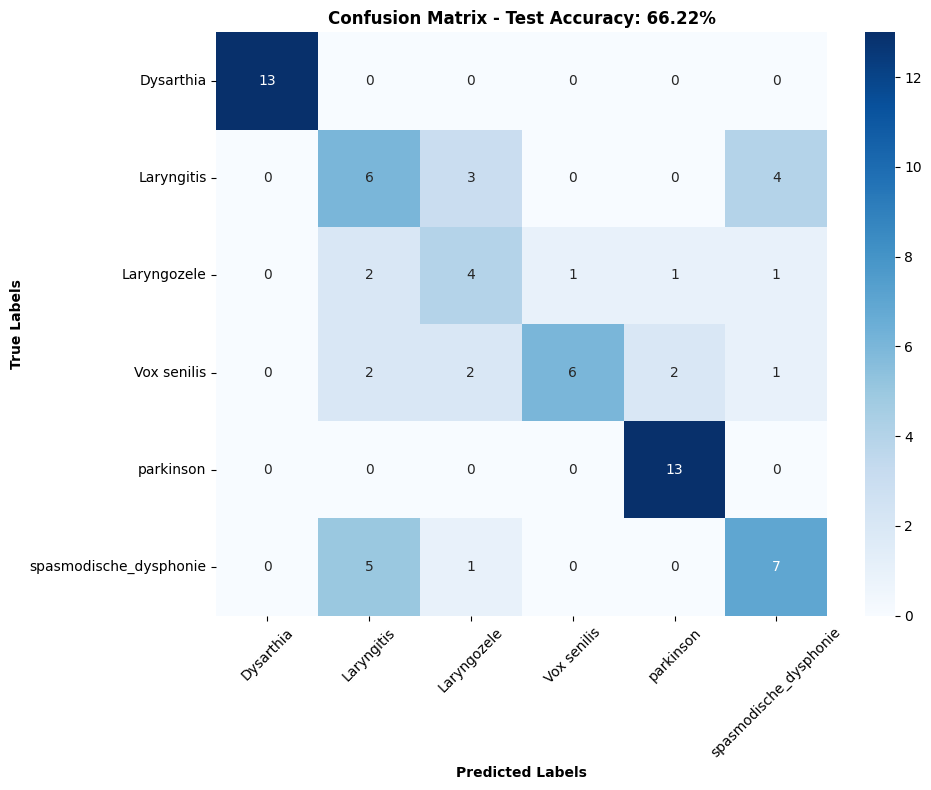

Current best validation accuracy: 80.82%. The new techniques should push this higher!


In [16]:
# Final Evaluation on the TEST SET
print("\n=== FINAL EVALUATION ON TEST SET ===")

# Load the best model
model.load_state_dict(torch.load('best_full_model_diet.pth'))

# Create test dataset and dataloader
test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', val_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"Final Test Loss: {test_loss:.4f}")

# Classification report
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes, digits=4))

# Confusion Matrix Visualization
def plot_confusion_matrix(true_labels, predictions, class_names, acc):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels', fontweight='bold')
    plt.ylabel('True Labels', fontweight='bold')
    plt.title(f'Confusion Matrix - Test Accuracy: {acc:.2%}', fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for the test set
plot_confusion_matrix(test_labels, test_preds, test_dataset.classes, test_acc)

if best_val_acc >= 0.90:
    print("🚀 CONGRATULATIONS! 90%+ VALIDATION ACCURACY ACHIEVED! 🚀")
else:
    print(f"Current best validation accuracy: {best_val_acc:.2%}. The new techniques should push this higher!")


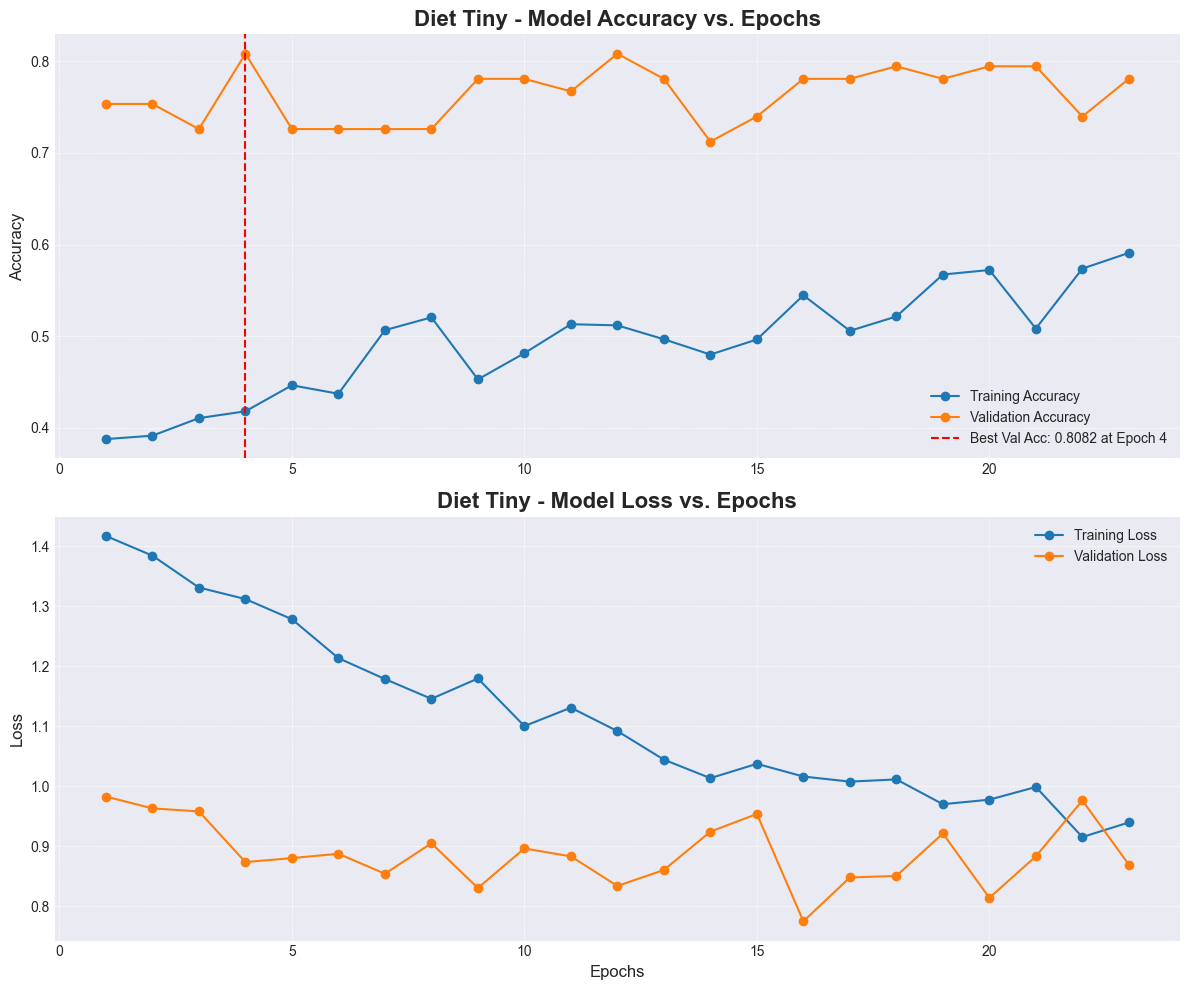

In [17]:
# Training History Visualization
import matplotlib.pyplot as plt

epochs_ran = range(1, len(history['train_loss']) + 1)

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Training & Validation Accuracy
ax1.plot(epochs_ran, history['train_acc'], 'o-', label='Training Accuracy')
ax1.plot(epochs_ran, history['val_acc'], 'o-', label='Validation Accuracy')
ax1.set_title('Diet Tiny - Model Accuracy vs. Epochs', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
best_acc_val = max(history['val_acc'])
ax1.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Val Acc: {best_acc_val:.4f} at Epoch {best_epoch}')
ax1.legend()

# Plot Training & Validation Loss
ax2.plot(epochs_ran, history['train_loss'], 'o-', label='Training Loss')
ax2.plot(epochs_ran, history['val_loss'], 'o-', label='Validation Loss')
ax2.set_title('Diet Tiny - Model Loss vs. Epochs', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [18]:
# Fine-Tuning Phase
print("🚀 STARTING FINAL FINE-TUNING PHASE FOR DIET TINY 🚀")

FT_EPOCHS = 10                  
FT_LEARNING_RATE = 5e-6         
BEST_MODEL_PATH = 'best_full_model_diet.pth'
FINETUNED_MODEL_PATH = 'best_finetuned_model_diet.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use validation transforms for both train and val (no augmentation)
_, ft_transform = get_enhanced_transforms(config['img_size'])
train_dataset_ft = MelSpectrogramDataset(config['base_dir'], 'train', ft_transform)
val_dataset_ft = MelSpectrogramDataset(config['base_dir'], 'validation', ft_transform)

train_loader_ft = DataLoader(train_dataset_ft, batch_size=config['batch_size'], shuffle=True)
val_loader_ft = DataLoader(val_dataset_ft, batch_size=config['batch_size'], shuffle=False)

# Instantiate and load model
model = EnhancedDietTransformerClassifier(
    config['model_name'], num_classes, config['drop_rate'], config['drop_path_rate']
).to(device)

model.load_state_dict(torch.load(BEST_MODEL_PATH))
print(f"✅ Successfully loaded weights from '{BEST_MODEL_PATH}'")

# Conservative optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=FT_LEARNING_RATE, 
    weight_decay=config['weight_decay'] * 0.1
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FT_EPOCHS, eta_min=FT_LEARNING_RATE * 0.1)

# Standard criterion (no label smoothing)
criterion = torch.nn.CrossEntropyLoss()

# Run Fine-Tuning Loop
best_ft_acc = 0.0
original_mixup = config.get('mixup_alpha', 0.4)
config['mixup_alpha'] = 0.0  # Disable mixup

for epoch in range(FT_EPOCHS):
    print(f"\n🎯 Fine-Tuning Epoch {epoch+1}/{FT_EPOCHS}")
    print(f"   Current LR: {optimizer.param_groups[0]['lr']:.2e}")

    train_loss, train_acc = train_epoch(model, train_loader_ft, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader_ft, criterion, device)
    
    scheduler.step()

    print(f"📈 FT - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"📊 FT - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_ft_acc:
        best_ft_acc = val_acc
        torch.save(model.state_dict(), FINETUNED_MODEL_PATH)
        print(f"💾 New best fine-tuned model saved! Acc: {val_acc:.4f}")

config['mixup_alpha'] = original_mixup

print(f"\n✅ Fine-tuning complete! Best accuracy: {best_ft_acc:.4f}")
print(f"💾 Final model saved to '{FINETUNED_MODEL_PATH}'")

🚀 STARTING FINAL FINE-TUNING PHASE FOR DIET TINY 🚀
Found 4021 images in train set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Found 73 images in validation set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Feature dimension for deit_tiny_patch16_224: 192
✅ Successfully loaded weights from 'best_full_model_diet.pth'

🎯 Fine-Tuning Epoch 1/10
   Current LR: 5.00e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, Loss=0.6164]


📈 FT - Train Loss: 0.8040, Train Acc: 0.6946
📊 FT - Val Loss: 0.6289, Val Acc: 0.7671
💾 New best fine-tuned model saved! Acc: 0.7671

🎯 Fine-Tuning Epoch 2/10
   Current LR: 4.89e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s, Loss=0.5403]


📈 FT - Train Loss: 0.7501, Train Acc: 0.7048
📊 FT - Val Loss: 0.5937, Val Acc: 0.7534

🎯 Fine-Tuning Epoch 3/10
   Current LR: 4.57e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s, Loss=0.5515]


📈 FT - Train Loss: 0.7217, Train Acc: 0.7239
📊 FT - Val Loss: 0.5808, Val Acc: 0.7534

🎯 Fine-Tuning Epoch 4/10
   Current LR: 4.07e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s, Loss=0.5945]


📈 FT - Train Loss: 0.6737, Train Acc: 0.7419
📊 FT - Val Loss: 0.5898, Val Acc: 0.7397

🎯 Fine-Tuning Epoch 5/10
   Current LR: 3.45e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s, Loss=0.4880]


📈 FT - Train Loss: 0.6560, Train Acc: 0.7518
📊 FT - Val Loss: 0.5480, Val Acc: 0.7534

🎯 Fine-Tuning Epoch 6/10
   Current LR: 2.75e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s, Loss=0.4383]


📈 FT - Train Loss: 0.6486, Train Acc: 0.7593
📊 FT - Val Loss: 0.5258, Val Acc: 0.7808
💾 New best fine-tuned model saved! Acc: 0.7808

🎯 Fine-Tuning Epoch 7/10
   Current LR: 2.05e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s, Loss=0.4669]


📈 FT - Train Loss: 0.6195, Train Acc: 0.7717
📊 FT - Val Loss: 0.5341, Val Acc: 0.7534

🎯 Fine-Tuning Epoch 8/10
   Current LR: 1.43e-06


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s, Loss=0.4604]


📈 FT - Train Loss: 0.6224, Train Acc: 0.7687
📊 FT - Val Loss: 0.5294, Val Acc: 0.7808

🎯 Fine-Tuning Epoch 9/10
   Current LR: 9.30e-07


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.71it/s, Loss=0.4528]


📈 FT - Train Loss: 0.6089, Train Acc: 0.7722
📊 FT - Val Loss: 0.5248, Val Acc: 0.7808

🎯 Fine-Tuning Epoch 10/10
   Current LR: 6.10e-07


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s, Loss=0.4773]

📈 FT - Train Loss: 0.6107, Train Acc: 0.7717
📊 FT - Val Loss: 0.5296, Val Acc: 0.7808

✅ Fine-tuning complete! Best accuracy: 0.7808
💾 Final model saved to 'best_finetuned_model_diet.pth'


🧪 FINAL EVALUATION OF DIET TINY MODEL ON TEST DATA
Found 74 images in test set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
📊 Test dataset: 74 samples
🎯 Number of classes: 6
📝 Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Feature dimension for deit_tiny_patch16_224: 192
✅ Loaded fine-tuned model from: best_finetuned_model_diet.pth
🔍 Generating predictions on test data...


Processing test batches: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


✅ Final Test Accuracy: 0.7162 (71.62%)


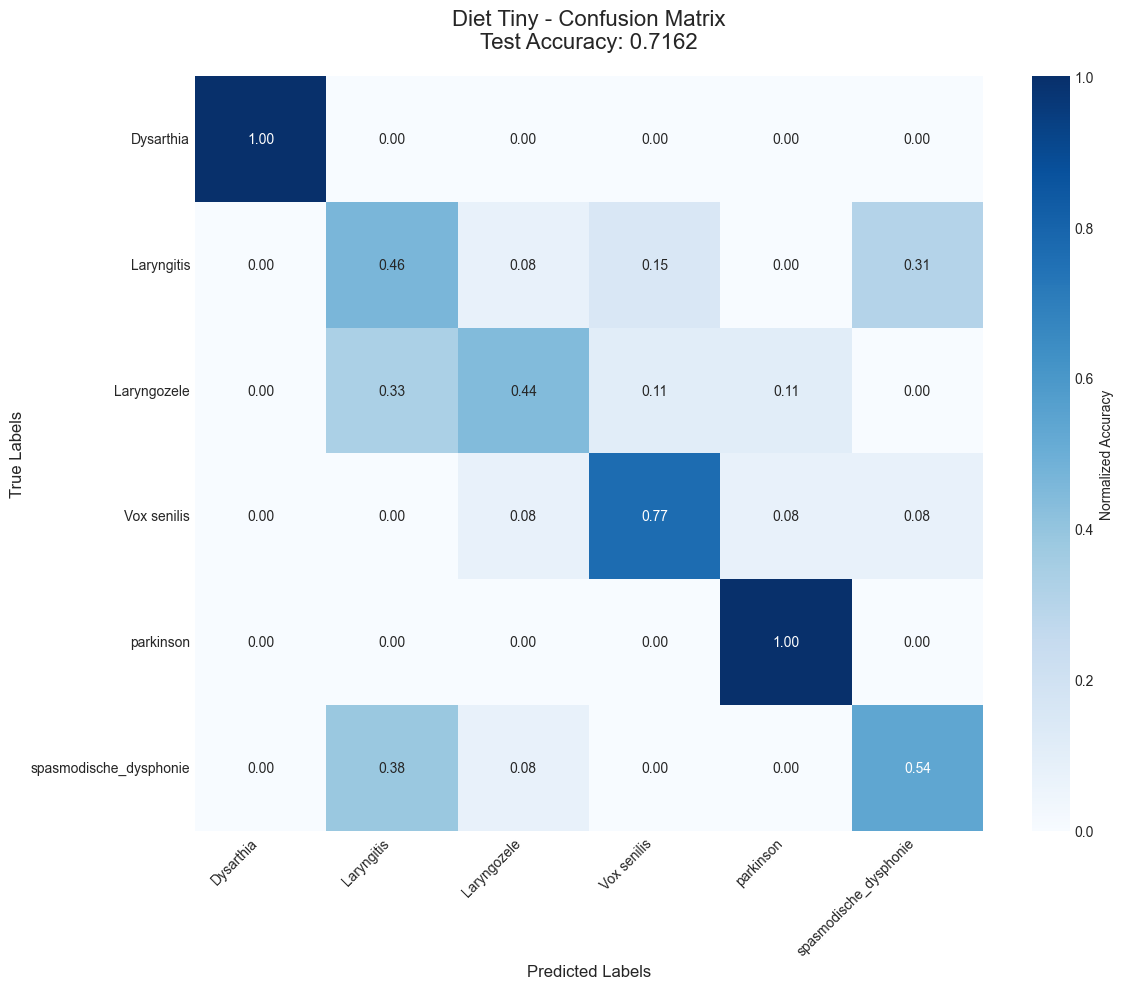


📊 DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.4286    0.4615    0.4444        13
           Laryngozele     0.5714    0.4444    0.5000         9
           Vox senilis     0.7692    0.7692    0.7692        13
             parkinson     0.8667    1.0000    0.9286        13
spasmodische_dysphonie     0.5833    0.5385    0.5600        13

              accuracy                         0.7162        74
             macro avg     0.7032    0.7023    0.7004        74
          weighted avg     0.7103    0.7162    0.7112        74


🔍 CONFUSION MATRIX ANALYSIS

Per-class Accuracy:
  Dysarthia: 1.0000 (13/13)
  Laryngitis: 0.4615 (6/13)
  Laryngozele: 0.4444 (4/9)
  Vox senilis: 0.7692 (10/13)
  parkinson: 1.0000 (13/13)
  spasmodische_dysphonie: 0.5385 (7/13)

🎉 DIET TINY TRAINING AND EVALUATION COMPLETE!
📈 Final Test Accuracy: 0.7162 (71.62%)


In [19]:
# Final Test Evaluation with Confusion Matrix
def plot_confusion_matrix_final(model, test_loader, device, class_names, save_path='confusion_matrix_diet_final.png'):
    model.eval()
    all_predictions = []
    all_targets = []
    
    print("🔍 Generating predictions on test data...")
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Processing test batches"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    test_accuracy = accuracy_score(all_targets, all_predictions)
    print(f"✅ Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Normalized Accuracy'})
    
    plt.title(f'Diet Tiny - Confusion Matrix\nTest Accuracy: {test_accuracy:.4f}', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm, all_predictions, all_targets, test_accuracy

# Final evaluation
FINETUNED_MODEL_PATH = 'best_finetuned_model_diet.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("🧪 FINAL EVALUATION OF DIET TINY MODEL ON TEST DATA")
print("="*50)

# Load test dataset
_, test_transform = get_enhanced_transforms(config['img_size'])
test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', test_transform)
test_loader = DataLoader(
    test_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False,
    num_workers=config.get('num_workers', 2),
    pin_memory=config.get('pin_memory', True)
)

class_names = test_dataset.classes
num_classes = len(class_names)

print(f"📊 Test dataset: {len(test_dataset)} samples")
print(f"🎯 Number of classes: {num_classes}")
print(f"📝 Classes: {class_names}")

# Load fine-tuned model
model = EnhancedDietTransformerClassifier(
    config['model_name'], 
    num_classes, 
    config['drop_rate'], 
    config['drop_path_rate']
).to(device)

model.load_state_dict(torch.load(FINETUNED_MODEL_PATH, map_location=device))
print(f"✅ Loaded fine-tuned model from: {FINETUNED_MODEL_PATH}")

# Generate final confusion matrix and results
cm, predictions, targets, test_accuracy = plot_confusion_matrix_final(
    model, test_loader, device, class_names
)

# Print detailed classification report
print("\n" + "="*60)
print("📊 DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(targets, predictions, target_names=class_names, digits=4))

# Analyze confusion matrix
print("\n" + "="*60)
print("🔍 CONFUSION MATRIX ANALYSIS")
print("="*60)

# Calculate per-class accuracy
print("\nPer-class Accuracy:")
for i, class_name in enumerate(class_names):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = correct / total if total > 0 else 0
    print(f"  {class_name}: {accuracy:.4f} ({correct}/{total})")

print(f"\n🎉 DIET TINY TRAINING AND EVALUATION COMPLETE!")
print(f"📈 Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")